In [9]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Importing MNIST dataset

In [10]:
dataset = MNIST(root=".", download=True)
train_val_dataset = MNIST(root=".", train=True, transform=ToTensor())
test_dataset = MNIST(root=".", train=False, transform=ToTensor())

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_val_dataset,
    [int(train_size), int(val_size)],
    generator=torch.Generator().manual_seed(42),
)

train_dataset, val_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x28402fb8b30>,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Set up data loader 

In [11]:
BATCH_SIZE = 1000
trainldr = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valldr = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testldr = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
for sample, label in trainldr:
    print(sample.shape)
    break

torch.Size([1000, 1, 28, 28])


## Define a simple CNN model

In [13]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Criterion, optimizer and scheduler setup

In [15]:
LR = 1e-4

model = cnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.1, patience=5
)

## Model training

In [16]:
num_epochs = 10
val_acc_max = 0.0

loss_epochs = []
loss_val_epochs = []
acc_epochs = []
acc_eval_epochs = []

for epoch in range(num_epochs):
    print("Epoch", epoch + 1)

    num_acc = 0.0
    running_loss = 0.0
    model.train()
    for inputs, labels in tqdm(trainldr):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        num_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = num_acc / len(train_dataset)

    loss_epochs.append(epoch_loss)
    acc_epochs.append(epoch_acc)

    num_val_acc = 0.0
    running_val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valldr):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            num_val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

    val_loss = running_val_loss / len(val_dataset)
    val_acc = num_val_acc / len(val_dataset)

    loss_val_epochs.append(val_loss)
    acc_eval_epochs.append(val_acc)

    scheduler.step(val_acc)

    torch.save(model.state_dict(), "./model/last_epoch.pt")

    if val_acc > val_acc_max:
        print(
            "Validation acc increased ({:.6f} --> {:.6f}).   Saving model ...".format(
                val_acc_max, val_acc
            )
        )
        torch.save(model.state_dict(), "./model/best.pt")
        val_acc_max = val_acc

    print(f"Loss: {epoch_loss:.4f}, Train_acc: {epoch_acc*100:.2f}")
    print(f"Val_loss: {val_loss:.4f}, Val_acc: {val_acc*100:.2f}")
    print("--------------------------------------------------------")

Epoch 1


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Validation acc increased (0.000000 --> 0.830250).   Saving model ...
Loss: 1.5804, Train_acc: 67.19
Val_loss: 0.7279, Val_acc: 83.03
--------------------------------------------------------
Epoch 2


100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Validation acc increased (0.830250 --> 0.897000).   Saving model ...
Loss: 0.5161, Train_acc: 85.66
Val_loss: 0.3709, Val_acc: 89.70
--------------------------------------------------------
Epoch 3


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Validation acc increased (0.897000 --> 0.921000).   Saving model ...
Loss: 0.3305, Train_acc: 90.49
Val_loss: 0.2806, Val_acc: 92.10
--------------------------------------------------------
Epoch 4


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Validation acc increased (0.921000 --> 0.933917).   Saving model ...
Loss: 0.2586, Train_acc: 92.53
Val_loss: 0.2286, Val_acc: 93.39
--------------------------------------------------------
Epoch 5


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation acc increased (0.933917 --> 0.943000).   Saving model ...
Loss: 0.2127, Train_acc: 93.80
Val_loss: 0.1894, Val_acc: 94.30
--------------------------------------------------------
Epoch 6


100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Validation acc increased (0.943000 --> 0.951667).   Saving model ...
Loss: 0.1795, Train_acc: 94.74
Val_loss: 0.1612, Val_acc: 95.17
--------------------------------------------------------
Epoch 7


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Validation acc increased (0.951667 --> 0.957500).   Saving model ...
Loss: 0.1536, Train_acc: 95.49
Val_loss: 0.1410, Val_acc: 95.75
--------------------------------------------------------
Epoch 8


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Validation acc increased (0.957500 --> 0.957750).   Saving model ...
Loss: 0.1405, Train_acc: 95.89
Val_loss: 0.1365, Val_acc: 95.78
--------------------------------------------------------
Epoch 9


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation acc increased (0.957750 --> 0.958667).   Saving model ...
Loss: 0.1384, Train_acc: 95.90
Val_loss: 0.1346, Val_acc: 95.87
--------------------------------------------------------
Epoch 10


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]

Validation acc increased (0.958667 --> 0.959750).   Saving model ...
Loss: 0.1346, Train_acc: 96.11
Val_loss: 0.1329, Val_acc: 95.97
--------------------------------------------------------


## Evaluation of the training process

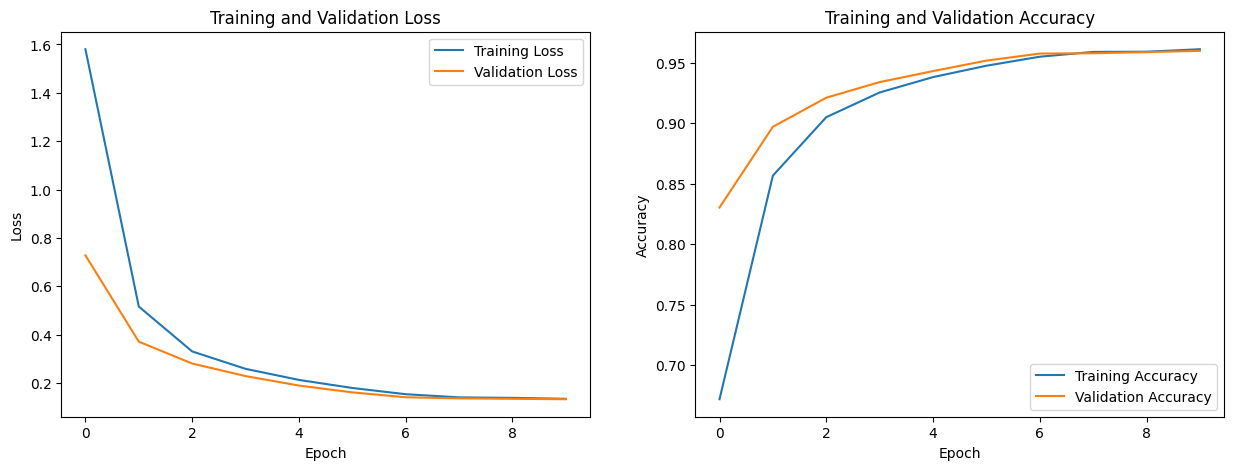

In [19]:
# Plotting the training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_epochs, label="Training Loss")
ax[0].plot(loss_val_epochs, label="Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].legend()

ax[1].plot(acc_epochs, label="Training Accuracy")
ax[1].plot(acc_eval_epochs, label="Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].legend()

## Confusion matrix on the test dataset

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


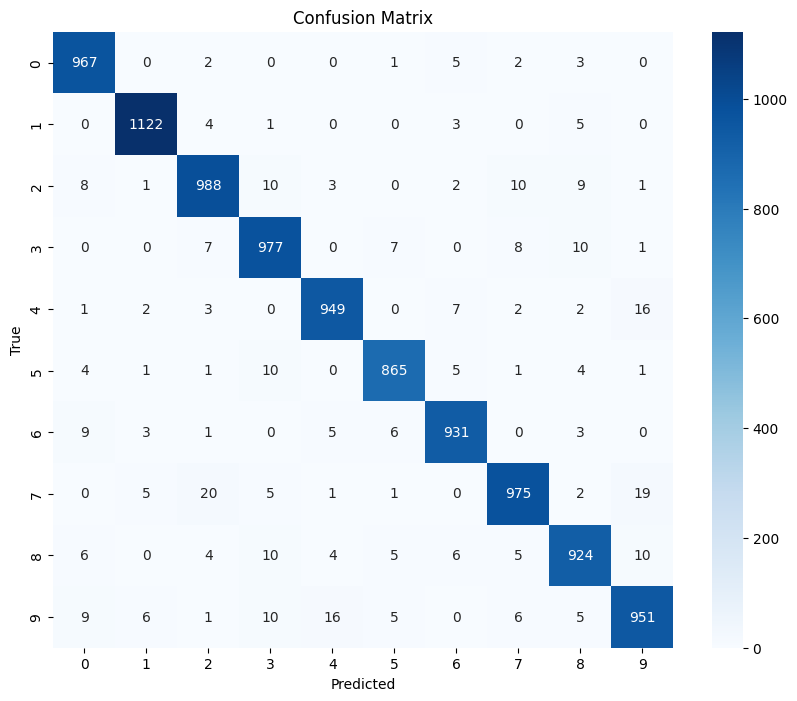

In [20]:
# Calculating the confusion matrix
model.load_state_dict(torch.load("./model/best.pt"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(testldr):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Displaying the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()